#Final Assignment - NYC Citi Bike Trips

**Overview**


After having analyzed our Citi Bike Usres, it was evident that there were some wins that could be delivered to those that purchase daily or three-day passes. Our goal was to futher analyze this data so that we could attempt to build an application that better supported them making the best decision for there specific use case. 

###Notebook Setup

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import datetime as dt
import geopy.geocoders
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.distance import vincenty
from geopy import distance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

###Analyze Citi Bike - Customer Data

After having cleaned an analyzed the larger Citi Bike dataset, a subset of 32,800 Customer records was generated for further exploratory research. The details below show the how this sample count was created. 

In [0]:
project_id = 'msds434-cohort-analysis-mvp'

In [12]:
from google.cloud import bigquery

client = bigquery.Client(project='msds434-cohort-analysis-mvp')

sample_count = 32800
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `msds434-cohort-analysis-mvp.citibikenyc_analysis.citibikenyc_customer`''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `msds434-cohort-analysis-mvp.citibikenyc_analysis.citibikenyc_customer`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)

Full dataset has 32800 rows


In [13]:
df.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,distance,minutes,age,season,dayofweek,hour
count,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000,32800.000000
mean,1378.390732,1341.486799,40.738972,-73.986088,1350.192988,40.738665,-73.986317,21067.373110,1981.658811,2054.348324,22.973179,38.341189,2.999726,4.052287,14.312561
std,991.509014,1314.280508,0.029592,0.018048,1319.817297,0.029695,0.018045,3745.836332,10.605750,1422.985358,16.525150,10.605750,0.019907,2.316054,4.036661
min,91.000000,72.000000,40.646768,-74.017134,72.000000,40.646768,-74.017134,14529.000000,1941.000000,0.000000,1.516667,22.000000,2.000000,1.000000,0.000000
25%,813.000000,347.000000,40.715348,-74.001567,347.000000,40.714979,-74.001971,17801.000000,1975.000000,1043.594437,13.550000,30.000000,3.000000,2.000000,12.000000
50%,1252.000000,486.000000,40.739974,-73.987895,485.000000,40.739323,-73.988084,21047.000000,1984.000000,1773.069320,20.866667,36.000000,3.000000,4.000000,14.000000
75%,1649.000000,3137.000000,40.762272,-73.973747,3137.000000,40.761227,-73.973747,24728.000000,1990.000000,2768.635402,27.483333,45.000000,3.000000,6.000000,17.000000
max,10770.000000,3431.000000,40.804213,-73.929891,3431.000000,40.804213,-73.929891,27316.000000,1998.000000,12244.655494,179.500000,79.000000,4.000000,7.000000,23.000000


####Data Clean Up

**Missing Data**: Confirm all missing data is removed from the dataset.

In [14]:
sample_df = df
#Percentage of missing data.
def missing_data(sample_df):
    total = sample_df.isnull().sum().sort_values(ascending=False)
    percent = (sample_df.isnull().sum()/sample_df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data(sample_df)

,Total,Percent
hour,0,0.0
end_station_latitude,0,0.0
starttime,0,0.0
stoptime,0,0.0
start_station_id,0,0.0
start_station_name,0,0.0
start_station_latitude,0,0.0
start_station_longitude,0,0.0
end_station_id,0,0.0
end_station_name,0,0.0


**Data Formatting:** In continuing to prep our Citi Bike data, establish formats will especially help will visualizaton needs. 

In [15]:
#Ensure data is formatted correctly to avoid errors in the visuals
sample_df['starttime'] = to_datetime(sample_df['starttime'])
sample_df['stoptime'] = to_datetime(sample_df['stoptime'])
sample_df['start_station_name'] = sample_df['start_station_name'].astype('category')
sample_df['end_station_name'] = sample_df['end_station_name'].astype('category')
sample_df['usertype'] = sample_df['usertype'].astype('category')
sample_df['gender'] = sample_df['gender'].astype('category')
round(sample_df.describe(),2)

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,distance,minutes,age,season,dayofweek,hour
count,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00,32800.00
mean,1378.39,1341.49,40.74,-73.99,1350.19,40.74,-73.99,21067.37,1981.66,2054.35,22.97,38.34,3.00,4.05,14.31
std,991.51,1314.28,0.03,0.02,1319.82,0.03,0.02,3745.84,10.61,1422.99,16.53,10.61,0.02,2.32,4.04
min,91.00,72.00,40.65,-74.02,72.00,40.65,-74.02,14529.00,1941.00,0.00,1.52,22.00,2.00,1.00,0.00
25%,813.00,347.00,40.72,-74.00,347.00,40.71,-74.00,17801.00,1975.00,1043.59,13.55,30.00,3.00,2.00,12.00
50%,1252.00,486.00,40.74,-73.99,485.00,40.74,-73.99,21047.00,1984.00,1773.07,20.87,36.00,3.00,4.00,14.00
75%,1649.00,3137.00,40.76,-73.97,3137.00,40.76,-73.97,24728.00,1990.00,2768.64,27.48,45.00,3.00,6.00,17.00
max,10770.00,3431.00,40.80,-73.93,3431.00,40.80,-73.93,27316.00,1998.00,12244.66,179.50,79.00,4.00,7.00,23.00


###Explore Key Variables

####Top 5 Citi Bike Stations

Let's review the top 5 stations for our Customer user types. 

In [0]:
#Data for Top 5 Stations visual
top5 = pd.DataFrame() 
top5['station']=sample_df['start_station_name'].value_counts().head().index
top5['number_of_starts']=sample_df['start_station_name'].value_counts().head().values
top5['station'] = top5['station'].cat.remove_unused_categories()
top5['station'] = top5['station'].astype('object')
#top5.sort_values(by = 'number_of_starts', ascending = False)

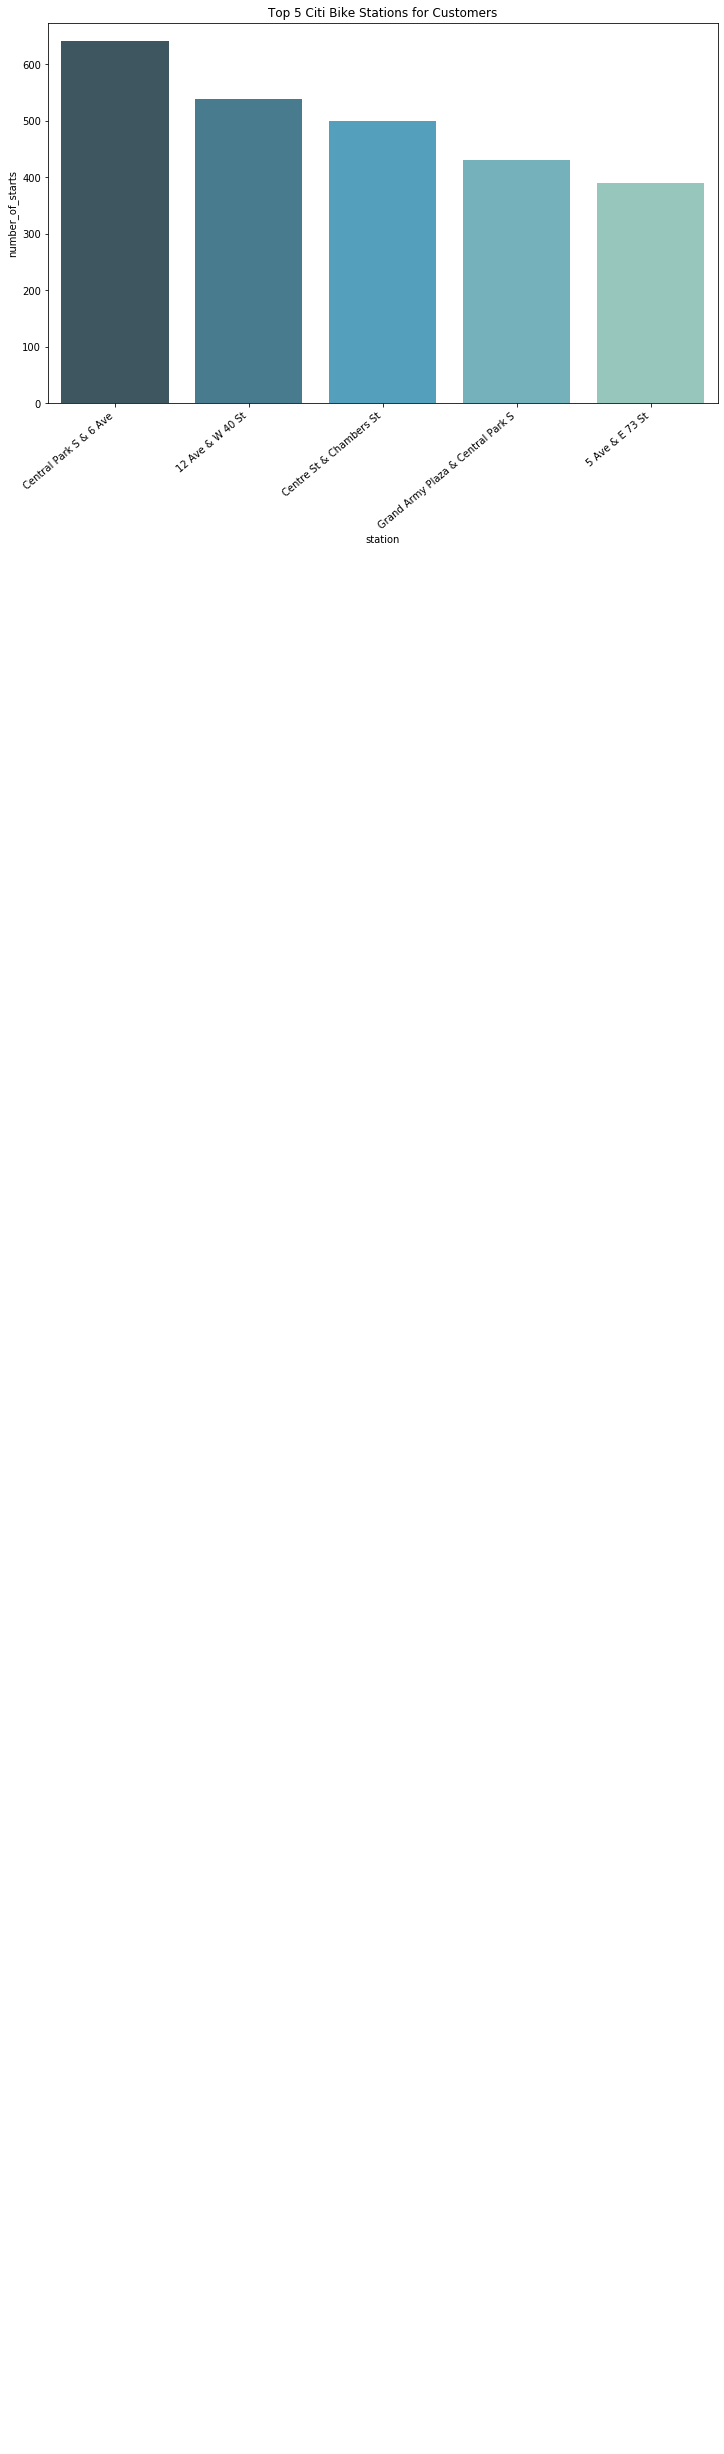

In [18]:
#Plot for Part 1: Top 5 Stations
ax = sns.barplot('station', 'number_of_starts', data = top5, palette="GnBu_d")
ax.set_title('Top 5 Citi Bike Stations for Customers', fontsize = 12)
rcParams['figure.figsize'] = 12,7
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha = 'right')
for index, row in top5.iterrows():
    ax.text(index,row['number_of_starts']-4000,row['number_of_starts'], 
            color='white', ha="center", fontsize = 10)
plt.show()

###Trip Duration by User Type

Other information that could be important for our prediction model will be the how each user type interacts with Citi bike.

In [0]:
#Calculate trip duration
TD_user = pd.DataFrame()
TD_user['averagminutes'] = round(sample_df.groupby('usertype')['minutes'].mean(),2)
TD_user = TD_user.reset_index()
TD_user['usertype'] = TD_user['usertype'].astype('object')

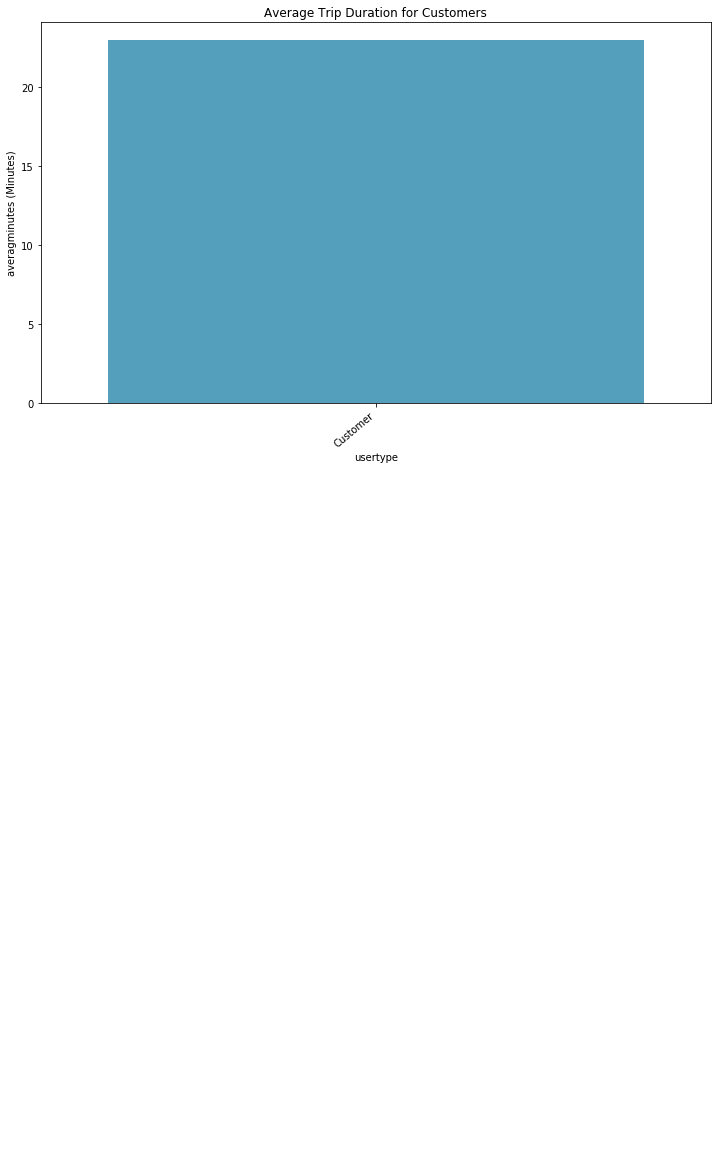

In [24]:
#Average trip Duration per User Type
ax2 = sns.barplot('usertype', 'averagminutes', data = TD_user,palette="GnBu_d")
ax2.set_title('Average Trip Duration for Customers')
#rcParams['figure.figsize'] = 12,7
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=40, ha = 'right')
ax2.set_ylabel('averagminutes (Minutes)')
for index, row in TD_user.iterrows():
    ax2.text(index,row['averagminutes']-70,(str(row['averagminutes'])), 
             color='white', ha="center", fontsize = 10)
plt.show()

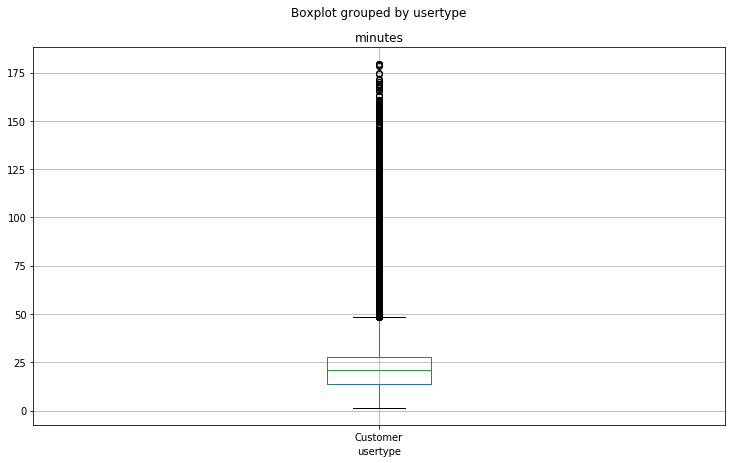

In [29]:
#Boxplots are more informative to visualize breakdown of data
df.boxplot('minutes', by = 'usertype')
plt.show()

Research suggest that our customers average at the 30 minute mark. This is important to note given that 30 minutes is the when different pricing models take affect. 

####Most Popular Trips

Research also indicates that it could be wise to assess the most poopular trips for our dataset, so we can assess which start and end location might require a 3-day pass to avoid charges over 30-minutes. 

In [0]:
#Identify the 10 most popular trips
trips_df = pd.DataFrame()
trips_df = sample_df.groupby(['start_station_name','end_station_name']).size().reset_index(name = 'numberoftrips')
trips_df = trips_df.sort_values('numberoftrips', ascending = False)
trips_df["start_station_name"] = trips_df["start_station_name"].astype(str)
trips_df["end_station_name"] = trips_df["end_station_name"].astype(str)
trips_df["trip"] = trips_df["start_station_name"] + " to " + trips_df["end_station_name"]
trips_df = trips_df[:10]
trips_df = trips_df.drop(['start_station_name', "end_station_name"], axis = 1)
trips_df = trips_df.reset_index()
#trips_df.head()

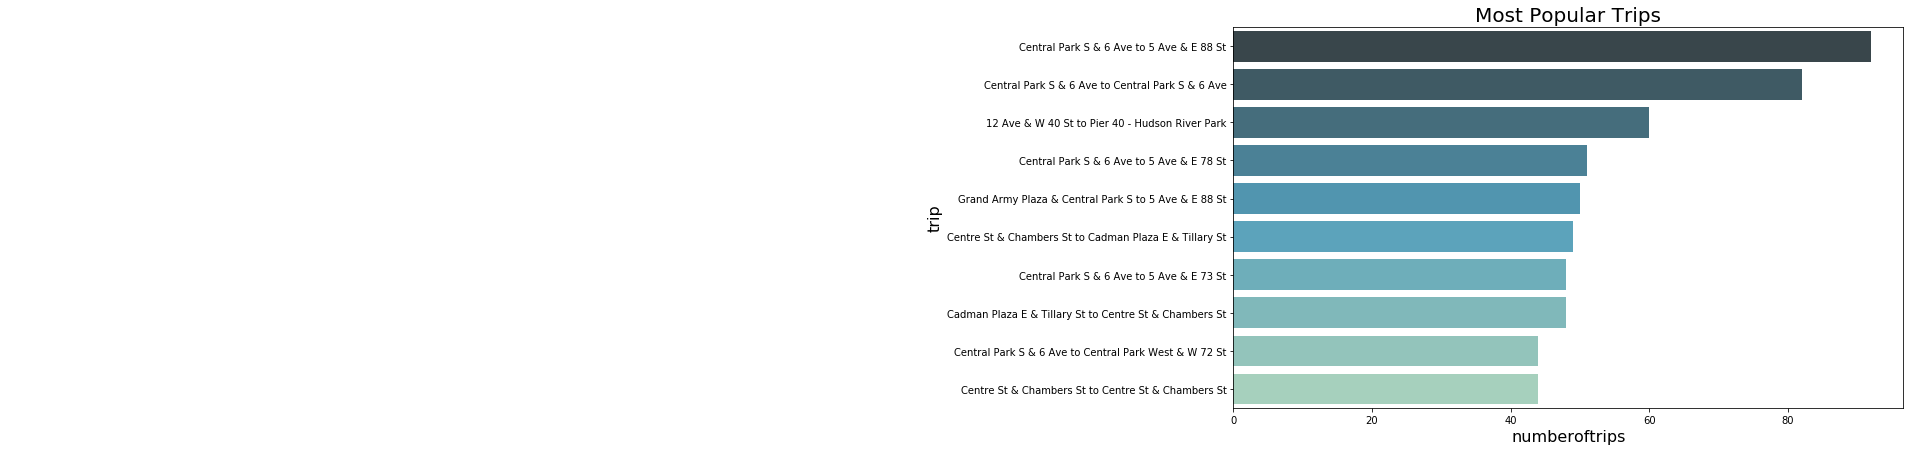

In [31]:
ax3 = sns.barplot('numberoftrips','trip', data = trips_df,palette="GnBu_d")
ax3.set_title('Most Popular Trips', fontsize = 20)
ax3.set_ylabel("trip",fontsize=16)
ax3.set_xlabel("numberoftrips",fontsize=16)
for index, row in trips_df.iterrows():
    ax3.text(row['numberoftrips']-220,index,row['numberoftrips'], 
             color='white', ha="center",fontsize = 10)
plt.show()

####Rider Performance by Age and Gender

Knowing how age and gender coorelates to performance will also be helpful for future modeling efforts

In [0]:
#Combine coordinates to calculate distance 
sample_df['start_coordinates'] = list(zip(sample_df['start_station_latitude'], sample_df['start_station_longitude']))
sample_df['end_coordinates'] = list(zip(sample_df['end_station_latitude'], sample_df['end_station_longitude']))

In [0]:
#Replace missing birth year by median based on speed and gender
sample_df['birth_year'] = sample_df.groupby(['gender','start_station_id'])['birth_year'].transform(lambda x: x.fillna(x.median()))

In [0]:
#if there are still a few nulls, drop these
sample_df = sample_df.dropna(subset=['birth_year'])

In [0]:
#Calculate age and drop circular/roundtrips
sample_df['age'] = 2020 - sample_df['birth_year']
sample_df['age'] = sample_df['age'].astype(int)

In [0]:
 dist = [] 
 for i in range(len(sample_df)): 
   dist.append(geopy.distance.vincenty(sample_df.iloc[i]['start_coordinates'],sample_df.iloc[i]['end_coordinates']).miles)
if (i%1000000==0): 
  print(i)

In [0]:
sample_df['distance'] = dist

In [0]:
sample_df = sample_df.drop(sample_df.index[(sample_df['distance'] == 0)])

In [0]:
#df[df['Trip Duration']<90]
#2. Followed the same reasoning as behind Birth Year. People in similar locations tend to also work in a similar industry or location
sample_df['distance'] = sample_df.groupby(['gender','start_station_id'])['distance'].transform(lambda x: x.fillna(x.median()))

In [0]:
sample_df['min_mile'] = round(sample_df['minutes']/sample_df['distance'], 2)
sample_df['mile_hour'] = round(sample_df['distance']/(sample_df['minutes']/60),2)

In [41]:
#Check for Data Integrity
round(sample_df.describe(),2)

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,distance,minutes,age,season,dayofweek,hour,min_mile,mile_hour
count,31471.00,31471.00,31471.00,31471.00,31471.0,31471.00,31471.00,31471.00,31471.00,31471.00,31471.00,31471.00,31471.00,31471.00,31471.00,31471.00,31471.00
mean,1374.09,1328.93,40.74,-73.99,1338.0,40.74,-73.99,21083.09,1981.65,1.33,22.90,38.35,3.00,4.05,14.32,23.72,3.86
std,950.95,1311.44,0.03,0.02,1317.3,0.03,0.02,3746.73,10.57,0.86,15.85,10.57,0.02,2.31,4.03,48.45,1.79
min,93.00,72.00,40.65,-74.02,72.0,40.65,-74.02,14529.00,1941.00,0.02,1.55,22.00,2.00,1.00,0.00,4.67,0.02
25%,829.00,345.00,40.72,-74.00,346.0,40.72,-74.00,17812.00,1975.00,0.69,13.82,30.00,3.00,2.00,12.00,12.07,2.60
50%,1256.00,484.00,40.74,-73.99,483.0,40.74,-73.99,21071.00,1984.00,1.15,20.93,36.00,3.00,4.00,14.00,15.99,3.75
75%,1645.00,3132.00,40.76,-73.97,3137.0,40.76,-73.97,24772.00,1990.00,1.75,27.42,45.00,3.00,6.00,17.00,23.10,4.97
max,10769.00,3431.00,40.80,-73.93,3431.0,40.80,-73.93,27316.00,1998.00,7.60,179.48,79.00,4.00,7.00,23.00,3025.84,12.84


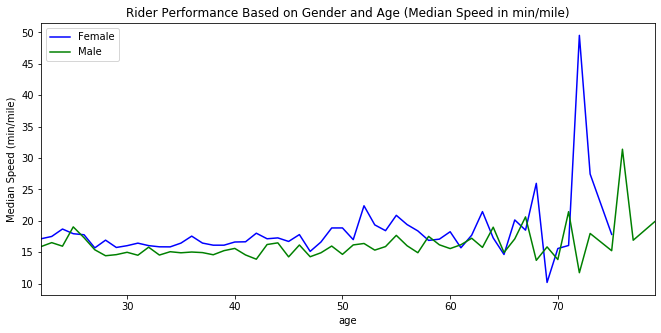

In [43]:
#Rider performance by age and Gender in Min/Mile 
fig, ax4 = plt.subplots(figsize=(11,5))
sample_df.groupby(['age','gender']).median()['min_mile'].unstack().plot(ax=ax4, color ="bg")
ax4.legend(['Female','Male'])
plt.ylabel('Median Speed (min/mile)')
plt.title('Rider Performance Based on Gender and Age (Median Speed in min/mile)')
plt.show()

##Predictive Modeling

Now that the data is cleaned an dunderstood, we can begin to build a model that predicts how long a trip will take given a starting point and destination.

In [0]:
model_1_df = sample_df

In [0]:
#create a random sample 
model_1_df = model_df.sample(frac = 0.1, random_state = 0)

In [95]:
model_1_df.columns.values

array(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid',
       'usertype', 'birth_year', 'gender', 'distance', 'minutes', 'age',
       'season', 'dayofweek', 'hour', 'start_coordinates',
       'end_coordinates', 'min_mile', 'mile_hour'], dtype=object)

In [0]:
def drop_data(model_1_df):
    model_1_df = model_1_df.drop(['tripduration','stoptime','start_station_id','start_station_latitude','start_station_longitude',
                  'start_coordinates','end_station_id', 'end_station_latitude', 'end_station_longitude', 
                  'end_coordinates','bikeid', 'start_station_name','birth_year','end_station_name','min_mile',
                  'mile_hour','season', 'dayofweek', 'age', 'hour'], axis = 1)
    return model_1_df

df_basemodel = drop_data(model_1_df)

In [0]:
df_basemodel = df_basemodel.drop('starttime', axis =1)

In [0]:
#Dummify categorical data and avoid dummy variable trap
df_basemodel = pd.get_dummies(df_basemodel, drop_first = True)

In [99]:
#review correlation
df_basemodel.corr().loc[:,'minutes']

distance       0.365025
minutes        1.000000
gender_male   -0.054919
Name: minutes, dtype: float64

In [0]:
#Train Test Split
#Predictor variable
X = df_basemodel.iloc[:,1:]
#Target variable
y = df_basemodel.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [101]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.049422534470254464

In [102]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     226.0
Date:                Wed, 11 Mar 2020   Prob (F-statistic):           5.69e-91
Time:                        00:35:16   Log-Likelihood:                -2958.1
No. Observations:                2517   AIC:                             5922.
Df Residuals:                    2514   BIC:                             5940.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8646      0.034     25.440      0.000       0.798       0.931
minutes         0.0196      0.001     21.255      0.000       0.018       0.021
gender_male     0.0230      0.032      0.715      0.474      -0.040       0.086
==============================================================================
Omnibus:                      360.670   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1085.999
Skew:                           0.741   Prob(JB):                    1.51e-236
Kurtosis:                       5.857   Cond. No.                         78.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Continue to refine this model by reviewing date. 
*   December - Feb. = Winter
*   March - May = Spring
*   June - Aug. = Summer
*   Sept. - Nov. = Fall

In [0]:
model_2_df = sample_df

In [0]:
def get_date_info(model_2_df):
    model_2_df['d_week'] = model_2_df['starttime'].dt.dayofweek
    model_2_df['m_yr'] = model_2_df['starttime'].dt.month
    model_2_df['ToD'] = model_2_df['starttime'].dt.hour

    model_2_df['d_week'] = (model_2_df['d_week']<5).astype(int)

    model_2_df['m_yr'] = model_2_df['m_yr'].replace(to_replace=[12,1,2], value = 0)
    model_2_df['m_yr'] = model_2_df['m_yr'].replace(to_replace=[3,4,5], value = 1)
    model_2_df['m_yr'] = model_2_df['m_yr'].replace(to_replace=[6,7,8], value = 2)
    model_2_df['m_yr'] = model_2_df['m_yr'].replace(to_replace=[9,10,11], value = 3)
    
    model_2_df['ToD'] = pd.cut(model_2_df['ToD'], bins=[-1, 5, 9, 14, 20, 25], labels=['Night','Morning','Afternoon','Evening','Night1'])
    model_2_df['ToD'] = model_2_df['ToD'].replace(to_replace='Night1', value = 'Night')
    model_2_df['ToD'] = model_2_df['ToD'].cat.remove_unused_categories()
    
    model_2_df['m_yr'] = model_2_df['m_yr'].astype('category')
    model_2_df['d_week'] = model_2_df['d_week'].astype('category')

    return(model_2_df)

In [0]:
#Dataset for the second model
df_model2 = drop_data(model_2_df)
df_model2 = get_date_info(df_model2)
df_model2 = df_model2.drop('starttime', axis =1)

In [0]:
#Dummify categorical data and avoid dummy variable trap
df_model2 = pd.get_dummies(df_model2, drop_first = True)

In [140]:
#review correlation
df_model2.corr().loc[:,'minutes']

distance         0.433833
minutes          1.000000
gender_male     -0.063686
d_week_1        -0.035577
m_yr_2           0.007511
m_yr_3          -0.008013
ToD_Morning      0.004801
ToD_Afternoon    0.067966
ToD_Evening     -0.039123
Name: minutes, dtype: float64

In [0]:
#Predictor variable
X = df_model2.iloc[:,1:]
#Target variable
y = df_model2.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [142]:
#Fit Linear Regression and check accuracy using sklearn
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.1427404229297814

In [143]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     799.9
Date:                Wed, 11 Mar 2020   Prob (F-statistic):               0.00
Time:                        00:52:35   Log-Likelihood:                -29210.
No. Observations:               25176   AIC:                         5.844e+04
Df Residuals:                   25167   BIC:                         5.851e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.5790      0.774     -4.623      0.000      -5.096      -2.062
minutes           0.0248      0.000     79.111      0.000       0.024       0.025
gender_male       0.0530      0.010      5.304      0.000       0.033       0.073
d_week_1         -0.0283      0.010     -2.887      0.004      -0.047      -0.009
m_yr_2            4.2986      0.773      5.557      0.000       2.783       5.815
m_yr_3            4.3070      0.773      5.568      0.000       2.791       5.823
ToD_Morning       0.1907      0.025      7.579      0.000       0.141       0.240
ToD_Afternoon    -0.0074      0.019     -0.389      0.697      -0.045       0.030
ToD_Evening       0.0313      0.019      1.658      0.097      -0.006       0.068
==============================================================================
Omnibus:                     3637.141   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16723.492
Skew:                           0.637   Prob(JB):                         0.00
Kurtosis:                       6.784   Cond. No.                     7.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's start to look at Start and End Locations

In [0]:
model_3_df = sample_df

In [0]:
def drop_data(model_1_df):
    model_1_df = model_1_df.drop(['tripduration','stoptime','distance','start_station_latitude','start_station_longitude',
                  'start_coordinates','end_station_latitude', 'end_station_longitude', 
                  'end_coordinates','bikeid', 'start_station_name','birth_year','end_station_name','min_mile',
                  'mile_hour','season', 'dayofweek', 'age', 'hour'], axis = 1)
    return model_1_df

df_basemodel = drop_data(model_3_df)

In [0]:
def get_date_info(model_3_df):
    model_3_df['d_week'] = model_3_df['starttime'].dt.dayofweek

    model_3_df['d_week'] = (model_3_df['d_week']<5).astype(int)

    return(model_3_df)

In [0]:
#Dataset for the second model
df_model3 = drop_data(model_3_df)
df_model3 = get_date_info(df_model3)
df_model3 = df_model3.drop('starttime', axis =1)

In [0]:
#Dummify categorical data and avoid dummy variable trap
df_model3 = pd.get_dummies(df_model3, drop_first = True)

In [173]:
#review correlation
df_model3.corr().loc[:,'minutes']

start_station_id    0.037891
end_station_id      0.048748
minutes             1.000000
d_week             -0.035577
gender_male        -0.063686
Name: minutes, dtype: float64

In [0]:
#Predictor variable
X = df_model3.iloc[:,1:]
#Target variable
y = df_model3.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [175]:
#Fit Linear Regression and check accuracy using sklearn
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test,y_test)

0.11443490403480305

In [176]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
regressor_OLS = sm.OLS(y_train, X_train).fit()
regressor_OLS.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       start_station_id   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     793.0
Date:                Wed, 11 Mar 2020   Prob (F-statistic):               0.00
Time:                        00:56:32   Log-Likelihood:            -2.1493e+05
No. Observations:               25176   AIC:                         4.299e+05
Df Residuals:                   25171   BIC:                         4.299e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            904.9974     20.631     43.866      0.000     864.559     945.436
end_station_id     0.3293      0.006     55.652      0.000       0.318       0.341
minutes            1.6039      0.500      3.208      0.001       0.624       2.584
d_week           -60.5457     15.624     -3.875      0.000     -91.171     -29.921
gender_male      -40.4832     15.953     -2.538      0.011     -71.752      -9.215
==============================================================================
Omnibus:                     7472.970   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2602.240
Skew:                           0.603   Prob(JB):                         0.00
Kurtosis:                       1.988   Cond. No.                     5.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's continue to explore this logistic regression using AutoML Tables